In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
from numpy import ma
from BBalpha_dropout import *
from keras.layers import Input
import tensorflow as tf
from toolbox import load_dataset

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [3]:
dataset = 'mnist'
file_name = './saved_models/{}-cnn-alpha0.5-run1/model.h5'.format(dataset)
model = load_model(file_name, custom_objects={'bbalpha_loss': bbalpha_softmax_cross_entropy_with_mc_logits(0.5),
                                              'metric_avg_acc': metric_avg_acc,
                                              'metric_avg_ll': metric_avg_ll})
_, _, test = load_dataset.load_mnist(flatten=False, channels_first=False)

In [4]:
# input_dim = (test[0].shape[1], test[0].shape[2])
# input_channels = test[0].shape[3]
# input_shape = (input_dim[0], input_dim[1], input_channels) # (dimX, )
input_shape = model.layers[0].input_shape[1:] # remove None dimension
inp = Input(shape=input_shape)

In [5]:
nb_test = 100
mc_logits = GenerateMCSamples(inp, model.layers[1:-1], nb_test) # repeats stochastic layers nb_test
mc_softmax = Activation('softmax', name='softmax')(mc_logits)  # softmax is over last dim
test_model = Model(inputs=inp, outputs=mc_softmax) # check the dimensions of this model

In [9]:
tf.trainable_variables()

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(4608, 100) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(100, 10) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'SGD/iterations:0' shape=() dtype=int64_ref>,
 <tf.Variable 'SGD/lr:0' shape=() dtype=float32_ref>,
 <tf.Variable 'SGD/momentum:0' shape=() dtype=float32_ref>,
 <tf.Variable 'SGD/decay:0' shape=() dtype=float32_ref>,
 <tf.Variable 'training/SGD/Variable:0' shape=(3, 3, 1, 32) dtype=float32_ref>,
 <tf.Variable 'training/SGD/Variable_1:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'training/SGD/Variable_2:0' shape=(3, 3, 32, 32) dtype=fl

In [6]:
x = tf.placeholder(tf.float32, shape=(None,) + input_shape)

In [7]:
def MC_dropout(model, x, n_mc):
    pred_mc = model(x) # N x K x D
    if n_mc > 1:
        pred = tf.reduce_mean(pred_mc, 1)
    else:
        pred = pred_mc
    return pred_mc, pred

In [8]:
def tf_log2(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(2, dtype=numerator.dtype))
    return numerator / denominator

In [9]:
pred_mc, predictions = MC_dropout(test_model, x, n_mc = nb_test)

In [10]:
plogp = predictions * tf_log2(tf.clip_by_value(predictions,1e-10,1.0))
predictive_uncertainty = - tf.reduce_sum(plogp, axis=1)
predictive_uncertainty

<tf.Tensor 'Neg:0' shape=(?,) dtype=float32>

In [11]:
plogp_mc = pred_mc * tf_log2(tf.clip_by_value(pred_mc,1e-10,1.0))
aleatoric_uncertainty = - 1 / nb_test * tf.reduce_sum(plogp_mc, axis=(1,2))
aleatoric_uncertainty

<tf.Tensor 'mul_2:0' shape=(?,) dtype=float32>

In [12]:
epistemic_uncertainty = predictive_uncertainty - aleatoric_uncertainty
epistemic_uncertainty

<tf.Tensor 'sub:0' shape=(?,) dtype=float32>

In [13]:
predictive_grad, = tf.gradients(predictive_uncertainty, x)
predictive_grad = tf.stop_gradient(predictive_grad)

In [14]:
epistemic_grad, = tf.gradients(epistemic_uncertainty, x)
epistemic_grad = tf.stop_gradient(epistemic_grad)

In [15]:
aleatoric_grad, = tf.gradients(aleatoric_uncertainty, x)
aleatoric_grad = tf.stop_gradient(aleatoric_grad)

In [16]:
output_grads = []
for ii in range(10):
    output_grad, = tf.gradients(predictions[:, ii], x)
    output_grads.append(tf.stop_gradient(output_grad))

In [17]:
[p_grad, a_grad, e_grad, preds] = sess.run([predictive_grad, aleatoric_grad, epistemic_grad, predictions], feed_dict={x: test[0]})
# p_grad = sess.run(predictive_grad, feed_dict={x: test[0]})

In [18]:
# o_grads = sess.run(output_grads, feed_dict={x: test[0]})

1


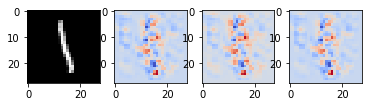

In [30]:
# plot train data
ind = 189
print(np.argmax(preds[ind, :]))
f, axes = plt.subplots(1, 4)
axes[0].imshow(test[0][ind, :, :, 0], cmap='gray')
im1 = axes[1].imshow(p_grad[ind, :, :, 0], cmap='coolwarm')
im2 = axes[2].imshow(a_grad[ind, :, :, 0], cmap='coolwarm')
im3 = axes[3].imshow(e_grad[ind, :, :, 0], cmap='coolwarm')


# ims = []
# for (ax, grad) in zip(axes[1:], [p_grad, a_grad, e_grad]):
#     ims.append(ax.imshow(grad[ind, :, :, 0], cmap='coolwarm'))
# [f.colorbar(im,fraction=0.046, pad=0.04) for im in ims]


1
0.9999999


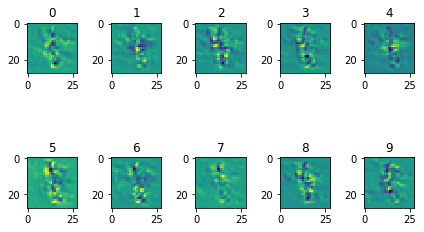

In [31]:
# print(np.argmax(preds[ind, :]))
# print(np.sum(preds[ind, :]))
# f, axes = plt.subplots(2, 5)
# axes = [ax for x in axes for ax in x]
# for (ii, ax) in enumerate(axes):
#     ax.imshow(o_grads[ii][ind, :, :, 0])
#     ax.set_title(ii)
# f.tight_layout()

In [21]:
np.mean(np.argmax(preds, axis=-1) == np.argmax(test[1], axis=-1))

0.9925

# building model with uncertainties

In [1]:
from BBalpha_dropout import *

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset = 'mnist'
filepath = './saved_models/{}-cnn-alpha0.5-run1/model.h5'.format(dataset)
outputpath = 'temp/model_w_uncertainty'
K_mc_test = 100

In [3]:
add_uncertainty_to_model(filepath, outputpath, K_mc_test)

# loading model with uncertainties

In [1]:
import tensorflow as tf
import numpy as np
from toolbox.load_dataset import load_mnist
_, validation, _ = load_mnist(flatten=False, channels_first=False)

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sess = tf.InteractiveSession()
# new_saver = tf.train.import_meta_graph('./temp/my-model.meta')
new_saver = tf.train.import_meta_graph('temp/model_w_uncertainty.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./temp'))

INFO:tensorflow:Restoring parameters from ./temp/model_w_uncertainty


In [3]:
graph = tf.get_default_graph()
x = graph.get_tensor_by_name('x_ph:0')
pred_mc = graph.get_tensor_by_name('pred_mc:0')
pred = graph.get_tensor_by_name('pred:0')
predictive = graph.get_tensor_by_name('predictive_uncertainty:0')
aleatoric = graph.get_tensor_by_name('aleatoric_uncertainty:0')
epistemic = graph.get_tensor_by_name('epistemic_uncertainty:0')

In [6]:
[p, p_un, a_un] = sess.run([pred, predictive, aleatoric], feed_dict={x: validation[0]})

In [7]:
np.mean(np.argmax(p, axis=-1) == np.argmax(validation[1], axis=-1))

0.9921666666666666

# Add noise shape to model

In [2]:
dataset = 'mnist'
file_name = './saved_models/{}-cnn-alpha0.5-run1/model.h5'.format(dataset)
model = load_model(file_name, custom_objects={'bbalpha_loss': bbalpha_softmax_cross_entropy_with_mc_logits(0.5),
                                              'metric_avg_acc': metric_avg_acc,
                                              'metric_avg_ll': metric_avg_ll})
_, _, test = load_dataset.load_mnist(flatten=False, channels_first=False)

In [3]:
input_shape = model.layers[0].input_shape[1:]
inp = Input(shape=input_shape)

In [4]:
noise_shape

(1, 28, 28, 1)

In [22]:
layers = model.layers[1:-1]
for ii, layer in enumerate(layers):
    if 'lambda' in layer.name:
        noise_shape = (1,) + layers[ii-1].output_shape[1:] # omit N dim
        layers[ii] = Dropout_mc(0.5, noise_shape=noise_shape)
        print("Replacing Layer {}...noise shape: {}".format(ii, noise_shape))

Replacing Layer 6...noise shape: (1, 4608)
Replacing Layer 9...noise shape: (1, 100)


In [23]:
K_mc_test = 5
mc_logits = GenerateMCSamples(inp, layers, K_mc_test)

# gradients of uncertainty wrt weights

In [1]:
import tensorflow as tf
import numpy as np
from toolbox.load_dataset import load_mnist
_, validation, _ = load_mnist(flatten=False, channels_first=False)

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sess = tf.InteractiveSession()
# new_saver = tf.train.import_meta_graph('./temp/my-model.meta')
new_saver = tf.train.import_meta_graph('saved_models/mnist-cnn-alpha0.5-run1/model_w_uncertainty.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./saved_models/mnist-cnn-alpha0.5-run1'))

INFO:tensorflow:Restoring parameters from ./saved_models/mnist-cnn-alpha0.5-run1/model_w_uncertainty


In [3]:
graph = tf.get_default_graph()
x = graph.get_tensor_by_name('x_ph:0')
pred_mc = graph.get_tensor_by_name('pred_mc:0')
pred = graph.get_tensor_by_name('pred:0')
predictive = graph.get_tensor_by_name('predictive_uncertainty:0')
aleatoric = graph.get_tensor_by_name('aleatoric_uncertainty:0')
epistemic = graph.get_tensor_by_name('epistemic_uncertainty:0')

In [5]:
tf.trainable_variables()[:8]

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(4608, 100) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(100, 10) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32_ref>]

In [6]:
grads = tf.gradients(predictive, tf.trainable_variables()[:8], stop_gradients=tf.trainable_variables()[:8])

In [7]:
grads

[<tf.Tensor 'gradients/AddN_10:0' shape=(3, 3, 1, 32) dtype=float32>,
 <tf.Tensor 'gradients/AddN_9:0' shape=(32,) dtype=float32>,
 <tf.Tensor 'gradients/AddN_8:0' shape=(3, 3, 32, 32) dtype=float32>,
 <tf.Tensor 'gradients/AddN_7:0' shape=(32,) dtype=float32>,
 <tf.Tensor 'gradients/AddN_6:0' shape=(4608, 100) dtype=float32>,
 <tf.Tensor 'gradients/AddN_5:0' shape=(100,) dtype=float32>,
 <tf.Tensor 'gradients/AddN_4:0' shape=(100, 10) dtype=float32>,
 <tf.Tensor 'gradients/AddN_3:0' shape=(10,) dtype=float32>]

In [8]:
g = sess.run(grads, feed_dict={x: validation[0][:1]})

In [11]:
g[1].shape

(32,)